In [1]:
import pandas as pd
import numpy as np
from numpy import array
from skimage.io import imshow
from matplotlib import pyplot as plt

In [2]:
train = pd.read_pickle("./Data/train.pickle")
test = pd.read_pickle("./Data/test.pickle")
classes = open('./Data/classes.txt', 'r').read().split()

For some reason, the extract.py script left some pixel values as greater than 0 but less than 1.

In [3]:
# put more instances in testing to make it an 80/20 split



In [4]:
X_train = []
X_test = []
y_train = []
y_test = []

for elem in train:
    X_train.append(elem['features'])
    y_train.append(classes[np.argmax(elem['label'], axis=0)])
    
for elem in test:
    X_test.append(elem['features'])
    y_test.append(classes[np.argmax(elem['label'], axis=0)])

X_train = array(X_train).reshape((-1,50,50))
y_train = array(y_train)
X_test = array(X_test).reshape((-1,50,50))
y_test = array(y_test)

(145884, 50, 50)


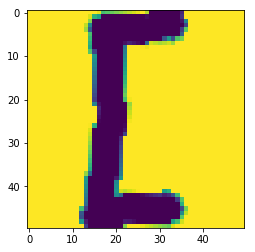

class: [


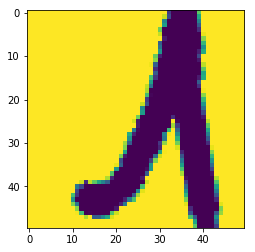

class: 1


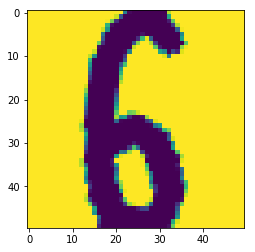

class: 6


In [9]:
print(X_train.shape)

for i in range(3):
    plt.imshow(X_train[i].squeeze())
    plt.show()
    print("class: " + y_train[i])